# Global Spatial Autocorrelation - Brexit

- summarize spatial distribution of values in a map
- does not identify areas which deviate from the expected
- quantify the departure from randomness

_Spatial Lag_ captures the behavior of variables in the immediate surroundings of each location
- binary will be the sum of the values of neighbors, et. for market potential
- row-standardized are 0 to 1, a local average

In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.viz import splot
from splot.esda import plot_moran
import contextily as ctx

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from numpy.random import seed

/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
ref = pd.read_csv('../data/brexit_vote.csv', index_col='Area_Code')
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382 entries, E06000031 to E08000036
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       382 non-null    int64  
 1   Region_Code              382 non-null    object 
 2   Region                   382 non-null    object 
 3   Area                     382 non-null    object 
 4   Electorate               382 non-null    int64  
 5   ExpectedBallots          382 non-null    int64  
 6   VerifiedBallotPapers     382 non-null    int64  
 7   Pct_Turnout              382 non-null    float64
 8   Votes_Cast               382 non-null    int64  
 9   Valid_Votes              382 non-null    int64  
 10  Remain                   382 non-null    int64  
 11  Leave                    382 non-null    int64  
 12  Rejected_Ballots         382 non-null    int64  
 13  No_official_mark         382 non-null    int64  
 14  Voting_for_both_a

In [3]:
lads = gpd.read_file(
    '../data/local_authority_districts.geojson'
).set_index('lad16cd')
lads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 391 entries, E06000001 to W06000023
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    391 non-null    int32   
 1   lad16nm     391 non-null    object  
 2   lad16nmw    22 non-null     object  
 3   bng_e       391 non-null    int32   
 4   bng_n       391 non-null    int32   
 5   long        391 non-null    float64 
 6   lat         391 non-null    float64 
 7   st_areasha  391 non-null    float64 
 8   st_lengths  391 non-null    float64 
 9   geometry    391 non-null    geometry
dtypes: float64(4), geometry(1), int32(3), object(2)
memory usage: 29.0+ KB


In [4]:
db = (
    gpd.GeoDataFrame(
        lads.join(ref[['Pct_Leave']]), crs=lads.crs
    ).to_crs(3857)[
        ['objectid', 'lad16nm', 'Pct_Leave', 'geometry']
    ].dropna()
)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int32   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(1)
memory usage: 13.4+ KB


In [5]:
db.index

Index(['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000010',
       'E06000011', 'E06000032', 'E06000005', 'E06000006', 'E06000033',
       ...
       'W06000024', 'W06000013', 'W06000014', 'W06000015', 'W06000016',
       'W06000018', 'W06000019', 'W06000021', 'W06000022', 'W06000023'],
      dtype='object', name='lad16cd', length=380)

In [6]:
lads.index

Index(['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000010',
       'E06000011', 'E06000032', 'E06000005', 'E06000006', 'E06000033',
       ...
       'W06000024', 'W06000013', 'W06000014', 'W06000015', 'W06000016',
       'W06000018', 'W06000019', 'W06000021', 'W06000022', 'W06000023'],
      dtype='object', name='lad16cd', length=391)

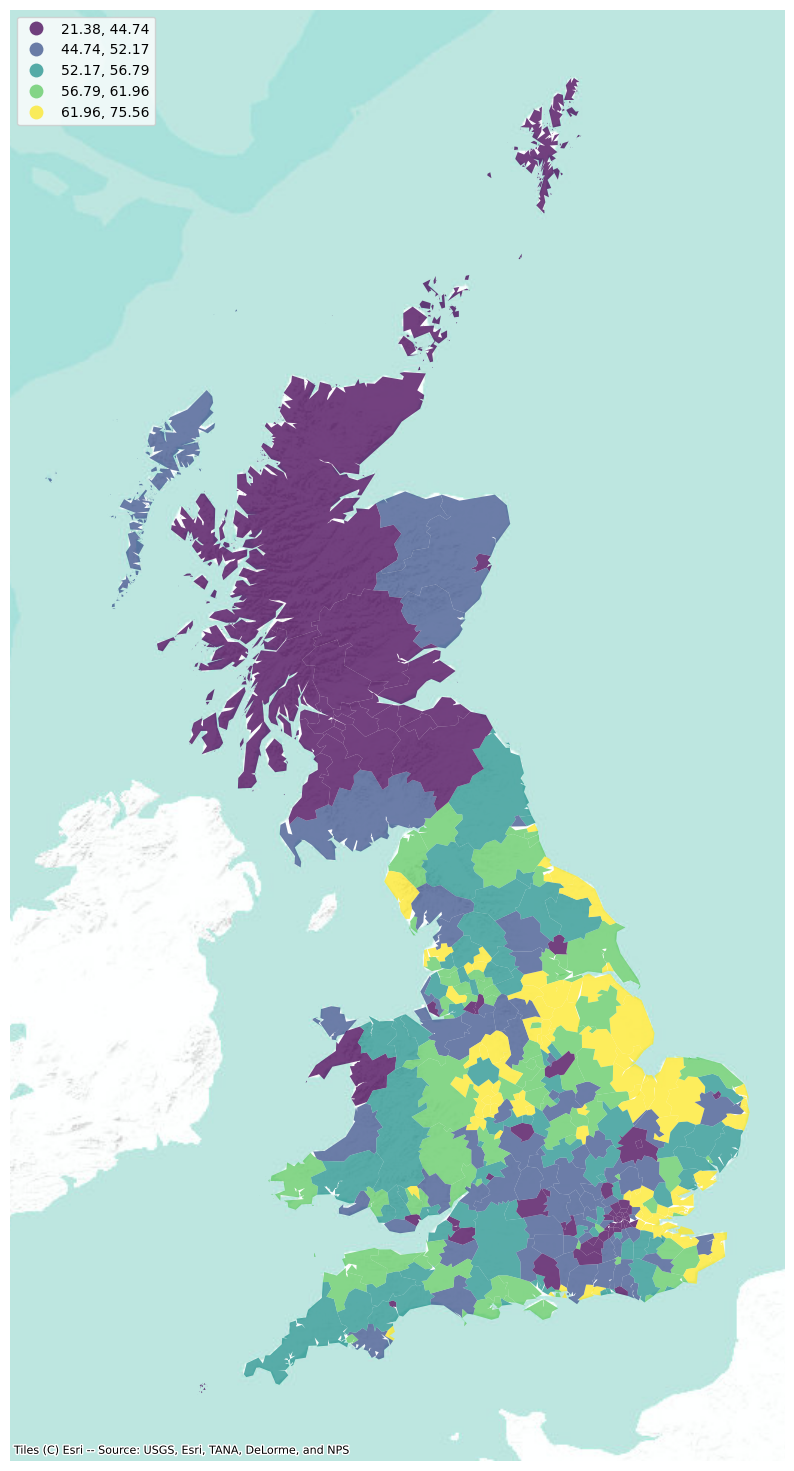

In [7]:
f, ax = plt.subplots(1, figsize=(10,20))
db.plot(
    column='Pct_Leave', 
    cmap='viridis', 
    scheme='quantiles', 
    k=5, 
    ec='w', lw=0.0, alpha=0.75, 
    legend=True, legend_kwds=dict(loc=2), 
    ax=ax
)
ctx.add_basemap(ax, crs=db.crs, source=ctx.providers.Esri.WorldTerrain)
ax.set_axis_off();

>get knn weights
>
>`transform = 'R'` applies row-standardization

In [8]:
w = weights.KNN.from_dataframe(db, k=8)
w.transform = 'R'

>Spatial lag

In [9]:
db['Pct_Leave_lag'] = weights.spatial_lag.lag_spatial(
    w, db.Pct_Leave
)

In [10]:
db.loc[["E08000012", "S12000019"], ["lad16nm", "Pct_Leave", "Pct_Leave_lag"]]

,lad16nm,Pct_Leave,Pct_Leave_lag
lad16cd,,,
E08000012,Liverpool,41.81,54.61375
S12000019,Midlothian,37.94,38.01875


>Liverpool voted very differently from its neighbors

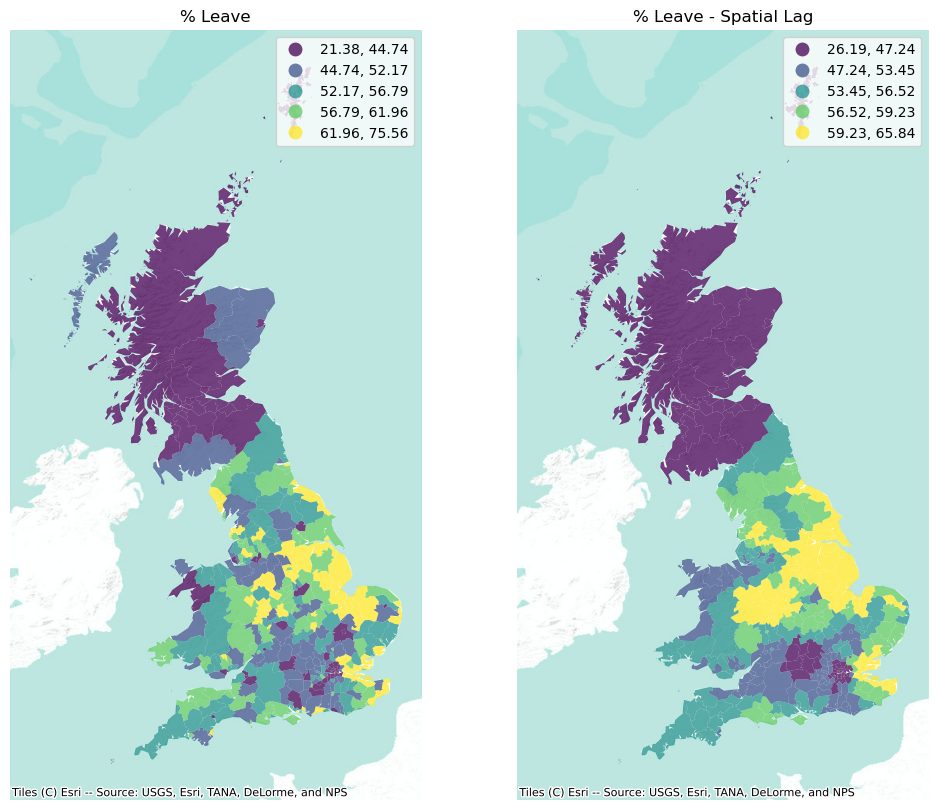

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
for column, ax in zip(("Pct_Leave", "Pct_Leave_lag"), (ax1, ax2)):
    db.plot(
        column=column, 
        cmap='viridis', 
        scheme='quantiles', k=5, 
        ec='w', lw=0.0, alpha=0.75, 
        legend=True, 
        ax=ax
    )
    ax.set_axis_off() 
    ctx.add_basemap(ax, crs=db.crs, source=ctx.providers.Esri.WorldTerrain)
ax1.set_title("% Leave")
ax2.set_title("% Leave - Spatial Lag");

# Binary case: join counts

>Relate behaviour of variable at a location to its local pattern
>
>Spatial autocorrelation measures will construct overall measures about trens in the dataset.
>
>Assess the extent to which local authorities that voted Leave were surrounded by others who voted leave.

In [12]:
db['Leave'] = (db["Pct_Leave"] > 50).astype(int)

In [13]:
db[['Pct_Leave', 'Leave']].tail()

,Pct_Leave,Leave
lad16cd,,
W06000018,57.63,1
W06000019,62.03,1
W06000021,49.56,0
W06000022,55.99,1
W06000023,53.74,1


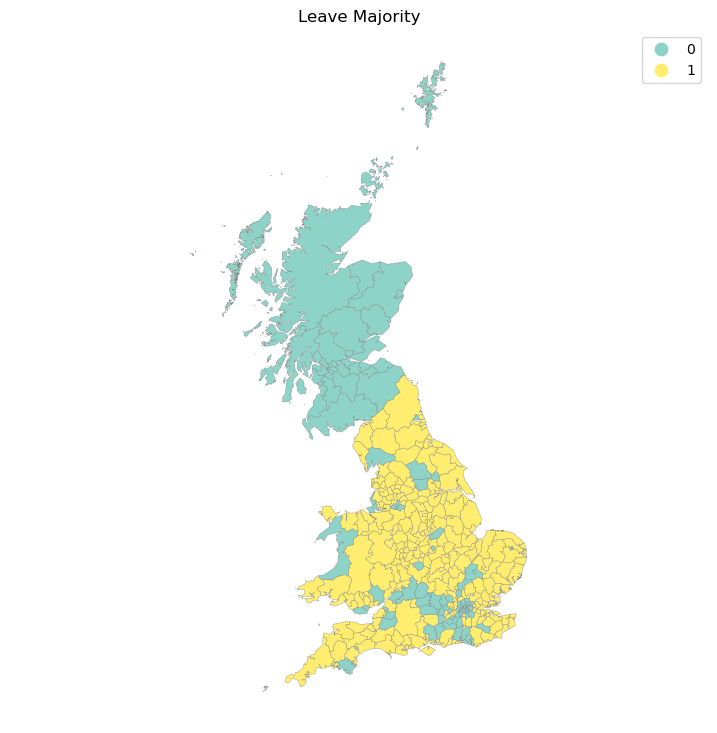

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="Leave",
    categorical=True,
    legend=True,
    ec="0.5", lw=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Leave Majority")
plt.axis("equal")
plt.show()

>The map shows positive spatial autocorrelation
>
>Joint count statistic counts GG/YY/GY borders to compare with a spatiall random situation
>
>This is a binary case, so the weights must be transformed from the standardized state

In [16]:
w.transform

'R'

In [17]:
w.transform = 'O'
w.transform

'O'

>Compute the statistic

In [19]:
seed(1234)
jc = esda.join_counts.Join_Counts(db['Leave'], w)
jc

In [28]:
print(f'''
   Number of GG occurences:        {jc.bb}
   Number of YY occurences:        {jc.ww} 
   Number of GY occurences:        {jc.bw}
   Total number of comparisons:   {jc.J}
   Expected mean for GG/YY joins:  {jc.mean_bb:.3f}
   Expected mean for GY joins:     {jc.mean_bw:.3f}
   Pseudo-p value for GG/YY:       {jc.p_sim_bb}
   Pseudo-p value for G/Y:         {jc.p_sim_bw}
''')


   Number of GG occurences:        871.0
   Number of YY occurences:        302.0 
   Number of GY occurences:        347.0
   Total number of comparisons:   1520.0
   Expected mean for GG/YY joins:  727.412
   Expected mean for GY joins:     649.323
   Pseudo-p value for GG/YY:       0.001
   Pseudo-p value for G/Y:         1.0



# Continuous Case = Moran's I

$$
I = \dfrac{n}{\sum_i\sum_j w_{ij}} \dfrac{\sum_i\sum_j w_{ij} \, z_i \, z_j}{\sum_i z_i^2}
$$

>A Moran Plot is a scatter plot that compares a variable of interest against its spatial lag. The variable is usually standardized.

In [29]:
db['Pct_Leave_std'] = db.Pct_Leave - db.Pct_Leave.mean() 
db['Pct_Leave_lag_std'] = weights.lag_spatial(
    w, db.Pct_Leave_std
)

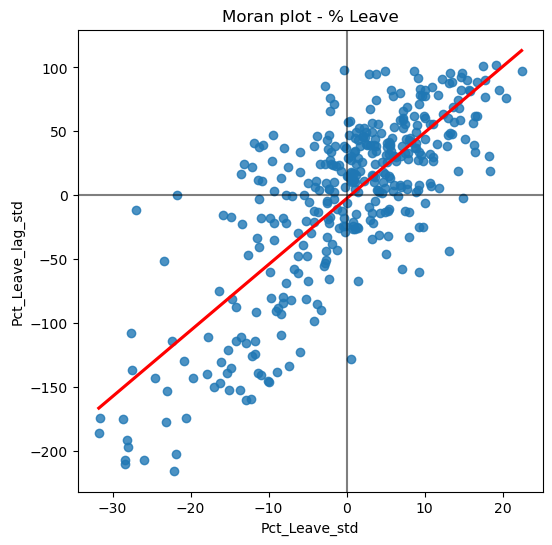

In [31]:
f, ax = plt.subplots(figsize=(6,6))
sns.regplot(
    x='Pct_Leave_std', 
    y='Pct_Leave_lag_std', 
    ci=None, 
    data=db, 
    line_kws={'color': 'r'}
)
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5) 
ax.set_title("Moran plot - % Leave");

>Positive autocorrelation is shown. To express it in numbers, use Moran's I
>
>Standardize the weights again

In [32]:
w.transform = 'R'
moran = esda.moran.Moran(db.Pct_Leave, w)

In [34]:
print(f'''
    Moran's I:          {moran.I}
    Simulation p-value: {moran.p_sim}
''')



    Moran's I:          0.6454521298096587
    Simulation p-value: 0.001



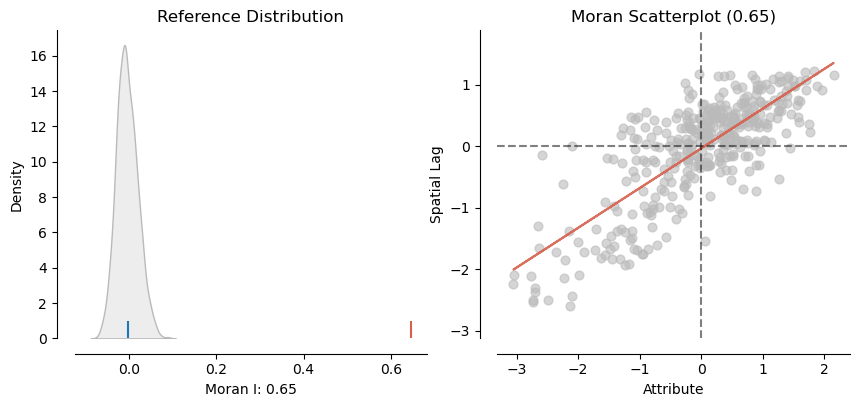

In [35]:
plot_moran(moran);

The blue rug is the random mean, the red is the mean from the dataset

# Geary's C 

A contiguity ratio

$$ 
C = \dfrac{(n-1)}
          {2 \sum_i \sum_j w_{ij}} 
    \dfrac{\sum_i \sum_j w_{ij} (y_i - y_{j})^2}
          {\sum_i (y_i - \bar{y})^2}
$$

In [38]:
geary = esda.geary.Geary(db.Pct_Leave, w)
print(f'''
    Geary's C:           {geary.C} 
    Simulations p-value: {geary.p_sim} 
''')


    Geary's C:           0.4080233215854691 
    Simulations p-value: 0.001 



# Getis and Ord's G 

- A measure of concentration but can be used for autocorrelation
- A statistic of positive ac, does not detect negative ac
- Common metric in Geographic Data Science

>Make sure each observation has at least one neighbor

In [49]:
from math import ceil

In [50]:
db_osgb = db.to_crs(27700)
pts = db_osgb.centroid
xys = pd.DataFrame(dict(X=pts.x, Y=pts.y))
min_thr = weights.util.min_threshold_distance(xys)
min_thr

180878.91800925438

In [51]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, ceil(min_thr))
gao = esda.getisord.G(db.Pct_Leave, w_db)
print(f''' 
    Getis & Ord G: {gao.G:.3f} 
    Psuedo P-val:  {gao.p_sim:.3f}
''')

 
    Getis & Ord G: 0.434 
    Psuedo P-val:  0.003

